In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
import models
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import dataloader as dataloader
import random
pth_path = '/home/hao/Downloads/ablation/best_audio_model.pth'
# 初始化模型和优化器
audio_model = models.Uni_CMAE_ablation(img_size=160, audio_length=1024, norm_pix_loss=True, encoder_depth=12, tr_pos=True, pred_t_dim=16)
optimizer = torch.optim.Adam(audio_model.parameters(), lr=0.0001)

mdl_weight = torch.load(pth_path, map_location=torch.device('cpu'))

# 处理键名不匹配问题
new_state_dict = {}
for k, v in mdl_weight.items():
    if k.startswith('module.'):
        k = k[len('module.'):]
    # if k not in ['decoder_pred_v.weight', 'decoder_pred_v.bias']:  # 忽略这些层
    #     new_state_dict[k] = v
    new_state_dict[k] = v
# # 调整 pos_embed_v 和 decoder_pos_embed_v 的形状 # TODO:后期在预训练模型里面调整，这个view的功能可以去掉
# if 'pos_embed_v' in new_state_dict:
#     new_state_dict['pos_embed_v'] = new_state_dict['pos_embed_v'].view(audio_model.pos_embed_v.shape)
# if 'decoder_pos_embed_v' in new_state_dict:
#     new_state_dict['decoder_pos_embed_v'] = new_state_dict['decoder_pos_embed_v'].view(audio_model.decoder_pos_embed_v.shape)

msg = audio_model.load_state_dict(new_state_dict, strict=False)

print('missing_keys:', msg.missing_keys)
print('unexpected_keys:', msg.unexpected_keys)


A Uni-CMAE Model
Use norm_pix_loss:  True
Learnable Positional Embedding:  True
img_size (160, 160) patch_size (16, 16) frames 16 t_patch_size 2
Number of Audio Patches: 512, Visual Patches: 800
pos_embed_v_t shape: torch.Size([1, 8, 768])
pos_embed_v_s shape: torch.Size([1, 100, 768])
pos_embed_v shape: torch.Size([1, 8, 100, 768])
decoder_pos_embed_v_t shape: torch.Size([1, 8, 384])
decoder_pos_embed_v_s shape: torch.Size([1, 100, 384])
decoder_pos_embed_v shape: torch.Size([1, 8, 100, 384])
decoder_pos_embed_v_trans shape: torch.Size([1, 800, 384])
Audio Positional Embedding Shape: torch.Size([1, 512, 768])
Visual Positional Embedding Shape: torch.Size([1, 8, 100, 768])
missing_keys: []
unexpected_keys: []


In [3]:

val_audio_conf = {
    'num_mel_bins': 128,
    'target_length': 1024,
    'freqm': 0,
    'timem': 0,
    'mixup': 0,
    'dataset': 'voxceleb2',
    'mode': 'test', # "pretrain", "finetune", "val", "test"
    'noise': False,
    'im_res': 160,
    'mean': -5.081,  # 添加 norm_mean
    'std': 4.4849    # 添加 norm_std
}
video_conf = {
    'dataset_type': 'video',
    'aa_type': "rand-m7-n4-mstd0.5-inc1",
    'pretrain_rand_flip': True,
    'pretrain_rand_erase_prob': 0.25,
    'pretrain_rand_erase_mode': "pixel",
    'pretrain_rand_erase_count': 1,
    'pretrain_rand_erase_split': False,
    'jitter_aspect_relative': [0.75, 1.3333],
    'jitter_scales_relative': [0.5, 1.0],
    'repeat_aug': 1,
    'num_retries': 10,
    'train_jitter_scales': (256, 320),
    'train_crop_size': 160,
    'train_random_horizontal_flip': True,
    'test_num_ensemble_views': 10,
    'test_num_spatial_crops': 3,
    'test_crop_size': 160,
    'sampling_rate': 4,
    'num_frames': 16,
    'target_fps': 30,
    'mean': (0.45, 0.45, 0.45),
    'std': (0.225, 0.225, 0.225),
    'enable_multi_thread_decode': False,
    'inverse_uniform_sampling': False,
    'use_offset_sampling': True
}
val_set = dataloader.AudiosetDataset(
    dataset_json_file='/home/hao/Project/uni-cmae/egs/voxceleb2/test_data.json',
    label_csv='/home/hao/Project/uni-cmae/egs/voxceleb2/class_labels_indices.csv',
    audio_conf=val_audio_conf,
    video_conf=video_conf,
)


Dataset has 36237 samples
Using Label Smoothing: 0.0
now using following mask: 0 freq, 0 time
now using mix-up with rate 0.000000
now process voxceleb2
using video data as video input
use dataset mean -5.081 and std 4.485 to normalize the input.
not use noise augmentation
number of classes is 1
now in test mode.
now using 160 * 160 image input
jitter_aspect_relative [0.75, 1.3333] jitter_scales_relative [0.5, 1.0]
Constructing DATASET test...
Perform standard augmentation


In [40]:

# 获取 val_set 中的一个样本
index = random.randint(0, len(val_set))
print(f'index: {index}') # 25931 559 颜色不会变，很好


index: 9033


In [41]:
if True:
    audio, video, label = val_set[index]

    audio_model.eval()
    # 前向传播
    pred_video, pred_audio, mask_v, mask_a, video, audio = audio_model.forward_vis(audio.unsqueeze(0), video.unsqueeze(0), mask_ratio_a=0.5, mask_ratio_v=0.8)

    # 处理输出数据的 shape
    video = video.squeeze(0).permute(1, 0, 2, 3).detach().cpu().numpy()  # (8, 3, 160, 160)
    audio = audio.squeeze(0).squeeze(0).transpose(0,1).detach().cpu().numpy()  # (1024, 128)
    pred_video = pred_video.squeeze(0).permute(1, 0, 2, 3).detach().cpu().numpy()  # (8, 3, 160, 160)
    pred_audio = pred_audio.squeeze(0).squeeze(0).transpose(0, 1).detach().cpu().numpy()  # (1024, 128)
    mask_v = mask_v.squeeze(0).detach().cpu().numpy()  # (800,)
    mask_a = mask_a.squeeze(0).detach().cpu().numpy()  # (512,)


    print(f'video shape: {video.shape}, audio shape: {audio.shape}')
    print(f'pred_video shape: {pred_video.shape}, pred_audio shape: {pred_audio.shape}')
    print(f'mask_v shape: {mask_v.shape}, mask_a shape: {mask_a.shape}')

    print(f'video min: {video.min()}, video max: {video.max()}')
    print(f'pred_video min: {pred_video.min()}, pred_video max: {pred_video.max()}')

    # Normalize video frames and predictions to [0, 1]
    video = (video - video.min()) / (video.max() - video.min())
    pred_video = (pred_video - pred_video.min()) / (pred_video.max() - pred_video.min())


pred_a shape: torch.Size([1, 512, 256]), pred_v shape: torch.Size([1, 800, 1536])
video shape: (16, 3, 160, 160), audio shape: (1024, 128)
pred_video shape: (16, 3, 160, 160), pred_audio shape: (1024, 128)
mask_v shape: (800,), mask_a shape: (512,)
video min: -2.0, video max: 1.5729849338531494
pred_video min: -2.994778633117676, pred_video max: 1.8254128694534302


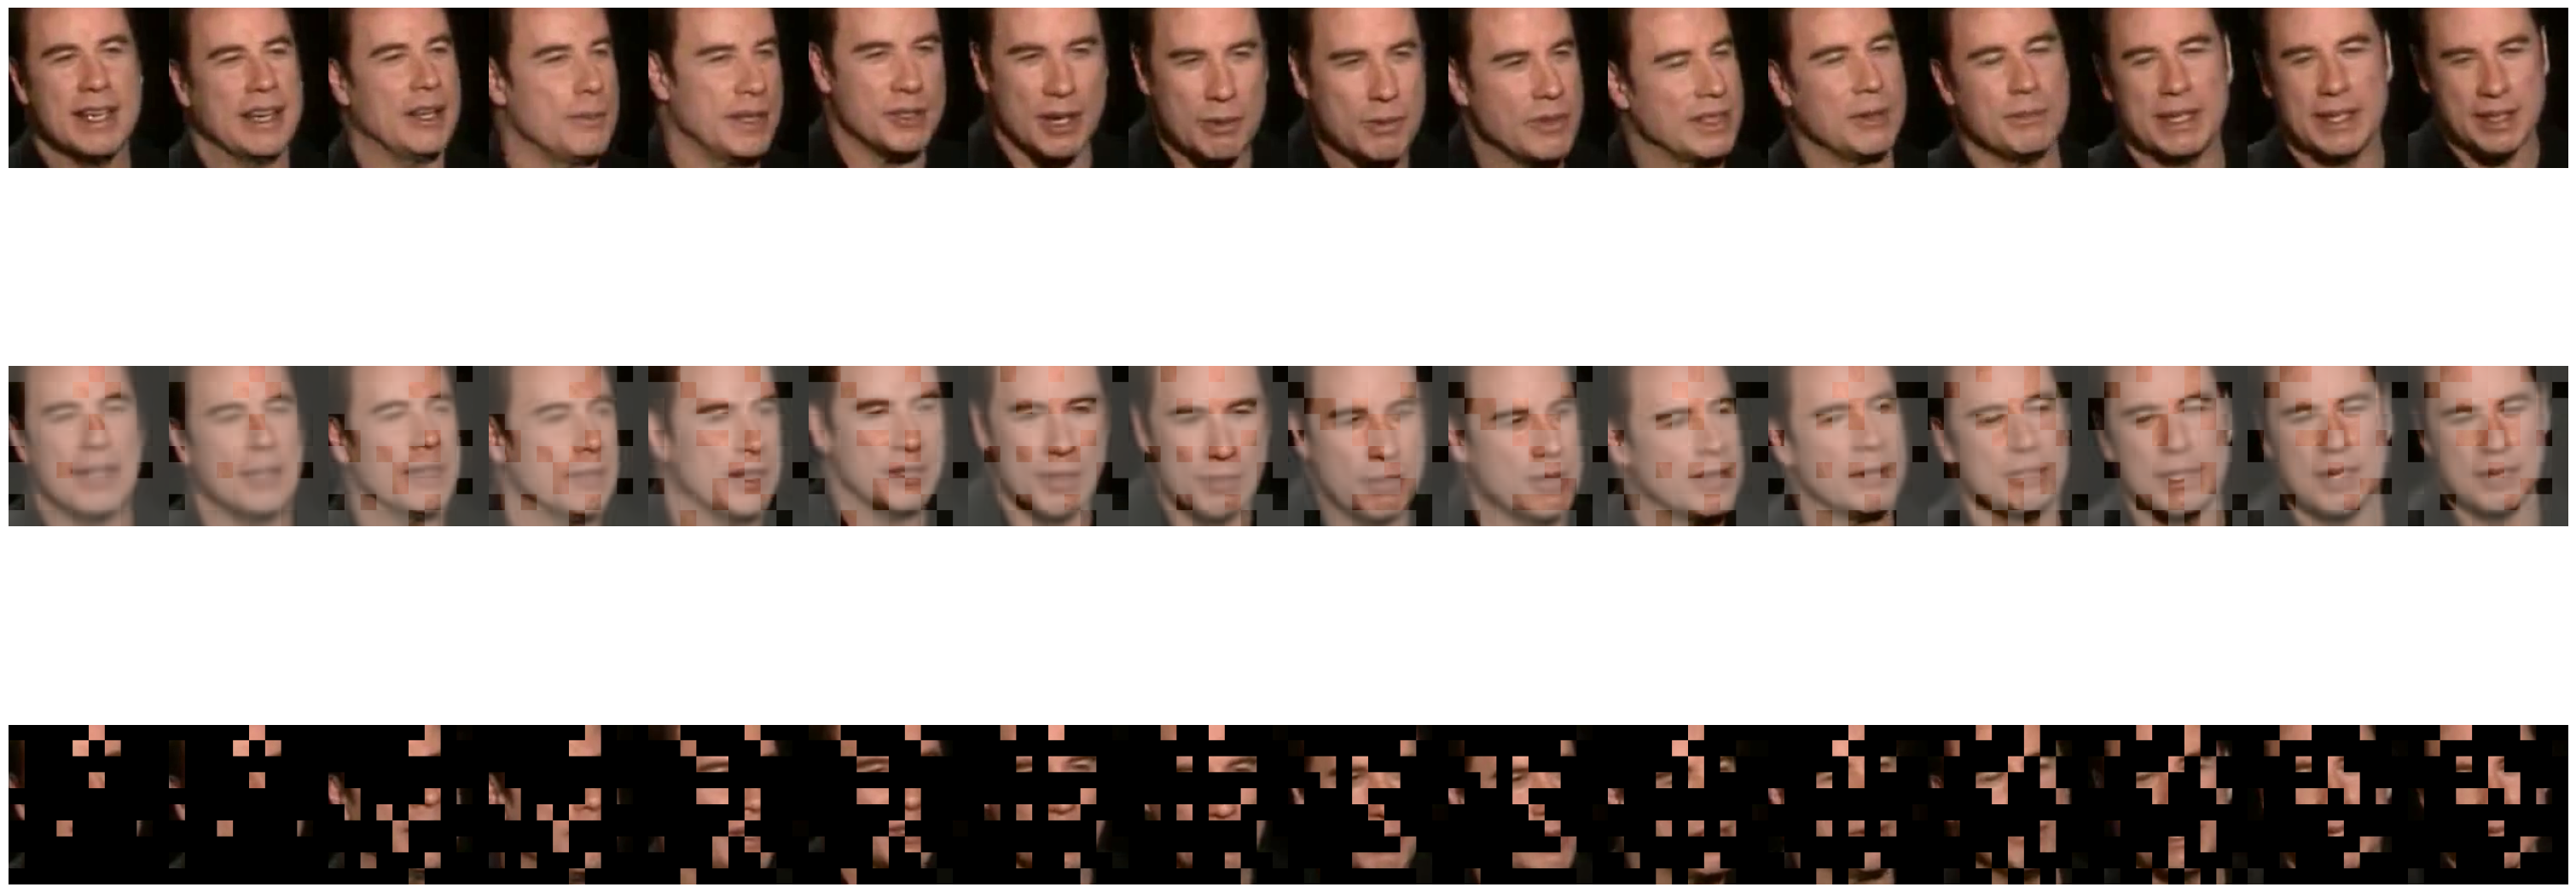

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Visualization
fig, axes = plt.subplots(3, video.shape[0], figsize=(30, 15))
patch_size = 16

for i in range(video.shape[0]):
    idx = i
    # Original video frame
    axes[0, idx].imshow(np.transpose(video[i], (1, 2, 0)))
    axes[0, idx].axis('off')

    # Predicted frame with real unmasked regions
    pred_frame_with_real = np.transpose(pred_video[i], (1, 2, 0)).copy()
    real_frame = np.transpose(video[i], (1, 2, 0)).copy()

    # Adjust mask shape to match video frames
    mask = mask_v.reshape(video.shape[0] // 2, video.shape[2] // patch_size, -1)
    mask = np.repeat(mask, 2, axis=0)  # Repeat mask for each pair of frames

    for y in range(mask.shape[1]):
        for x in range(mask.shape[2]):
            if mask[i, y, x] == 0:
                pred_frame_with_real[y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size, :] = \
                    real_frame[y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size, :]
    
    axes[1, idx].imshow(pred_frame_with_real)
    axes[1, idx].axis('off')
    
    # Masked original video frame
    masked_frame = video[i].copy()
    mask = mask_v[idx // 2 * (video.shape[2] // patch_size) * (video.shape[3] // patch_size):(idx // 2 + 1) * (video.shape[2] // patch_size) * (video.shape[3] // patch_size)]
    mask = mask.reshape(video.shape[2] // patch_size, video.shape[3] // patch_size)
    
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            if mask[y, x] > 0:
                masked_frame[:, y*patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size] = 0
    
    axes[2, idx].imshow(np.transpose(masked_frame, (1, 2, 0)))
    axes[2, idx].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

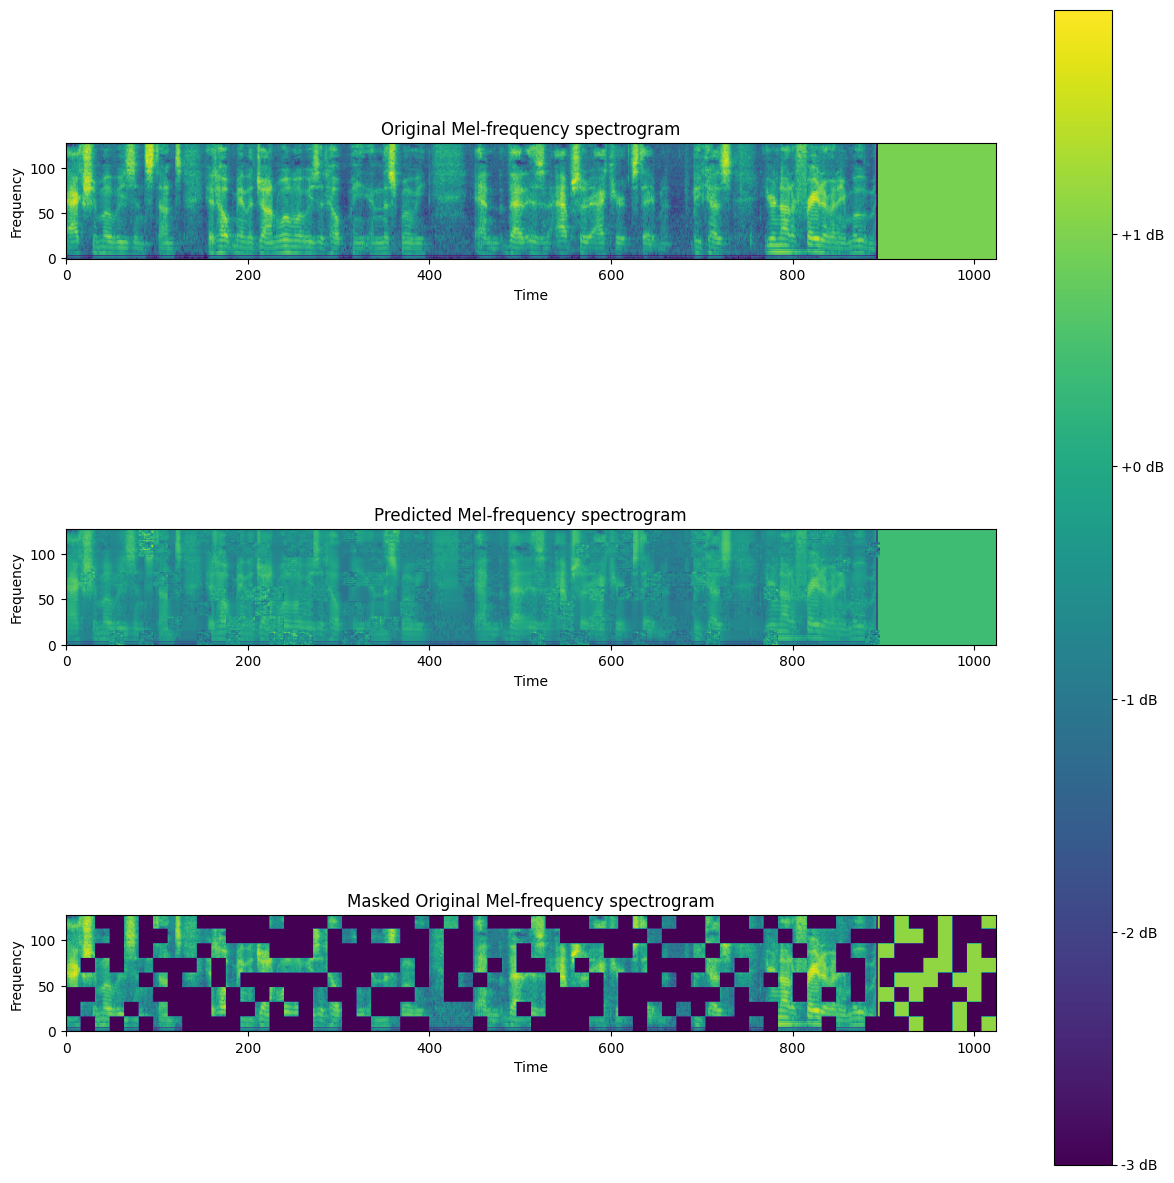

In [43]:
# 可视化原始频谱图、预测频谱图和掩码后的频谱图
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.01)  # 增加子图之间的间距

# 原始频谱图
im0 = axes[0].imshow(audio.T, aspect='equal', origin='lower')
axes[0].set_title('Original Mel-frequency spectrogram')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Frequency')

# 预测频谱图
pred_audio_copy = pred_audio.copy()
mask_a_copy = mask_a.reshape(-1, 8)
for i in range(mask_a_copy.shape[0]):
    for j in range(mask_a_copy.shape[1]):
        if mask_a_copy[i, j] == 0:
            pred_audio_copy[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16] = audio[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16]

im1 = axes[1].imshow(pred_audio_copy.T, aspect='equal', origin='lower')
axes[1].set_title('Predicted Mel-frequency spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')

# 掩码后的频谱图
masked_audio = audio.copy()
mask = mask_a.reshape(-1, 8)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if mask[i, j] > 0:
            masked_audio[i * 16:(i + 1) * 16, j * 16:(j + 1) * 16] = -3

im2 = axes[2].imshow(masked_audio.T, aspect='equal', origin='lower')
axes[2].set_title('Masked Original Mel-frequency spectrogram')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Frequency')

# 只显示一个颜色条
fig.colorbar(im2, ax=axes.ravel().tolist(), orientation='vertical', format='%+2.0f dB')

plt.show()

In [44]:
# import torch
# import numpy as np
# import torchaudio
# import librosa
# import soundfile as sf

# def reconstruct_audio(predicted_audio_path, pred_audio_copy, sr=16000, n_fft=400, hop_length=160, n_mels=128, fmin=0, fmax=None, n_iter=200):
#     if fmax is None:
#         fmax = sr / 2

#     # 将 pred_audio_copy 转换为梅尔频谱
#     mel_spectrogram = pred_audio_copy.T  # 形状为 (n_mels, t)

#     # 将自然对数尺度的梅尔谱转换为线性尺度
#     mel_spectrogram_linear = np.exp(mel_spectrogram)

#     # 获取梅尔滤波器
#     def get_mel_filterbank(sr, n_fft, n_mels, fmin, fmax):
#         # 创建 MelScale 对象
#         mel_scale = torchaudio.transforms.MelScale(
#             n_mels=n_mels,
#             sample_rate=sr,
#             f_min=fmin,
#             f_max=fmax,
#             n_stft=n_fft // 2 + 1,
#             norm=None,
#             mel_scale='htk'  # 与 htk_compat=True 保持一致
#         )
#         # 生成单位矩阵作为输入，以获取梅尔滤波器矩阵
#         freqs = torch.eye(n_fft // 2 + 1)
#         mel_fb = mel_scale(freqs)
#         # 转置以匹配形状
#         return mel_fb.numpy().T

#     mel_filterbank = get_mel_filterbank(sr, n_fft, n_mels, fmin, fmax)

#     # 计算梅尔滤波器的伪逆
#     mel_filterbank_inv = np.linalg.pinv(mel_filterbank)

#     # 计算线性频谱
#     linear_spectrogram = np.dot(mel_filterbank_inv.T, mel_spectrogram_linear)

#     # 由于线性谱可能出现负值，将其裁剪为非负
#     linear_spectrogram = np.maximum(linear_spectrogram, 0)

#     # 重建音频信号
#     def invert_spectrogram(linear_spectrogram, n_fft, hop_length, n_iter):
#         # 由于线性谱只对应正频率部分，需要还原完整频谱
#         full_spectrogram = np.vstack([
#             linear_spectrogram,
#             linear_spectrogram[-2:0:-1, :]
#         ])
#         # 使用 Griffin-Lim 算法
#         audio_signal = librosa.griffinlim(
#             S=full_spectrogram,
#             n_iter=n_iter,
#             hop_length=hop_length,
#             win_length=n_fft
#         )
#         return audio_signal

#     # 调用函数重建音频
#     predicted_audio_signal = invert_spectrogram(
#         linear_spectrogram,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_iter=n_iter
#     )

#     # 保存重建的音频
#     sf.write(predicted_audio_path, predicted_audio_signal, sr)

# # 示例调用
# predicted_audio_path = 'predict.wav'
# orignal_audio_path = 'orignal.wav'
# reconstruct_audio(predicted_audio_path, pred_audio_copy)
# reconstruct_audio(orignal_audio_path, audio)

In [45]:
# %reset -f